#*4.3.1	Random Forest: PyCaret Library*

#**Chapter 4.3.1**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.23.2
!pip install sklearn.utils
!pip install --upgrade scikit-learn
!pip install pycaret


In [ ]:
# Import librries 
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import glob #for maps
import plotly.graph_objects as go
import plotly.offline
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import itertools
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
warnings.filterwarnings("ignore")
import plotly.express as px
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
import pycaret
pycaret.__version__
from pycaret.utils import enable_colab
enable_colab()
from pycaret.regression import *

##**Data Preprocessing**

In [ ]:
#loop through all ground PM csv fileds and created a Pandas dataframe 

all_files = glob.glob('/content/gdrive/MyDrive/Sent/Ground/' +"*.csv")
all_files_1 = glob.glob('/content/gdrive/MyDrive/Sent/Ground1/' +"*.csv")
li = []
for filename in all_files:
  df= pd.read_csv(filename, index_col=None, header=0)
  li.append(df)

df = pd.concat(li, ignore_index=True)
li1 = []
for filename in all_files_1:
  df1= pd.read_csv(filename, index_col=None, header=0)
  li1.append(df1)

#they are stored in two folder, hence need to concat
df1 = pd.concat(li1, ignore_index=True)
data10= pd.concat([df,df1])
print(df.shape)
print(df1.shape)
print(data10.shape)
print(data10['country'].unique())
data10 = data10.loc[(data10['country'] == 'DE')] #choose Germany 

print(data10['parameter'].unique())
table = pd.pivot_table(data10, values='value', index=['city','utc','latitude','longitude'],columns=['parameter'])
table = table.reset_index()
print(table.head(5))
print(table.shape)
air_data_ground = table.fillna(table.mean())
air_data_ground = air_data_ground.loc[(air_data_ground['pm10'] < 20) & (air_data_ground['pm25'] < 20)] #select values that are below 20, to remove outliers 
air_data_ground["utc"] = pd.to_datetime(air_data_ground["utc"]).dt.normalize()
air_data_ground["utc"] = pd.to_datetime(air_data_ground["utc"]).dt.tz_localize(None)
air_data_ground=air_data_ground.groupby('utc')[['pm10', 'pm25']].mean()
air_data_ground = air_data_ground.reset_index()
air_data_ground 

#Read Sentinel Data 

fin_data = pd.read_csv('/content/gdrive/MyDrive/Sent/final_data_May20_Sept22.csv') #without outliers 


fig = px.line(data_frame=fin_data,y='nitrogendioxide_tropospheric_column', x='date')
#fig.update_layout({'yaxis': {'range': [0.1, 100]},'xaxis': {'range': [0.1, 100]}})
fig['layout'].pop('updatemenus')
fig.show()
fig = px.line(data_frame=fin_data,y='air_mass_factor_troposphere', x='date')
fig.update_traces(line_color='#147852')
#fig.update_layout({'yaxis': {'range': [0.1, 100]},'xaxis': {'range': [0.1, 100]}})
fig['layout'].pop('updatemenus')
fig.show()
fig = px.line(data_frame=fin_data,y='pm10', x='date')
fig.update_traces(line_color='#456987')
#fig.update_layout({'yaxis': {'range': [0.1, 100]},'xaxis': {'range': [0.1, 100]}})
fig['layout'].pop('updatemenus')
fig.show()
#fig, ax = plt.subplots(2,1,figsize = (20, 20))
fig, ax = plt.subplots(figsize = (20, 15))
ax.plot(fin_data['date'], fin_data['pm10'], color='blue')
ax.set_xlabel('Months')
ax.set_ylabel('Pm10', color='blue')
#ax[0].set_ylim([500, 8000])

ax2 = ax.twinx()
ax2.plot(fin_data['date'], fin_data['pm25'],color='red')

ax2.set_ylabel('Pm25', color='red')
#ax2.set_ylim([500, 8000])
plt.title('Particulate Matter')
#data_LSTM_test0=fin_data.drop(columns=['date', 'utc', 'pm25','tm5_tropopause_layer_index', 'latitude', 'longitute', 'Year', 'Month', 'Day', 'Hour', 'qa_value','air_mass_factor_troposphere', 'air_mass_factor_total'])
data_LSTM_test1=fin_data.drop(columns=['date', 'utc', 'pm25','tm5_tropopause_layer_index', 'latitude', 'longitute', 'Year', 'Month', 'Day', 'Hour', 'qa_value'])

In [ ]:
data_LSTM_test= fin_data.groupby(['utc'])['nitrogendioxide_tropospheric_column','nitrogendioxide_tropospheric_column_precision','nitrogendioxide_tropospheric_column_precision_kernel',	'pm10'].mean()

In [ ]:
data_LSTM_test = data_LSTM_test.reset_index()

In [ ]:
data_LSTM_test.head()

,utc,nitrogendioxide_tropospheric_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,pm10,MA12
0,2020-05-01,0.000012,0.000012,0.000012,6.261500,13.306267
1,2020-05-02,0.000037,0.000017,0.000015,7.395500,13.306267
2,2020-05-03,0.000041,0.000021,0.000020,10.091111,13.306267
3,2020-05-04,0.000055,0.000029,0.000027,15.311250,13.306267
4,2020-05-05,0.000028,0.000016,0.000015,10.266667,13.306267


In [ ]:
# create 12 month moving average
import plotly
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
data_LSTM_test['MA12'] = data_LSTM_test['pm10'].rolling(12).mean()
# plot the data and MA
import plotly.express as px
fig = px.line(data_LSTM_test, x="utc", y=["pm10", "MA12"], template = 'plotly_dark')
fig.show()
#variance looks tstationart, there shuldn't be some periodic info, check if the data is stationary, to use moving average approach, this applies to size of the windows size. Dickey-uller test

In [ ]:
data_LSTM_test = data_LSTM_test.reset_index()

In [ ]:
data_LSTM_test.head()

,utc,nitrogendioxide_tropospheric_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,pm10
0,2020-05-01,0.000012,0.000012,0.000012,6.261500
1,2020-05-02,0.000037,0.000017,0.000015,7.395500
2,2020-05-03,0.000041,0.000021,0.000020,10.091111
3,2020-05-04,0.000055,0.000029,0.000027,15.311250
4,2020-05-05,0.000028,0.000016,0.000015,10.266667


In [ ]:
data_LSTM_test['utc'] = pd.to_datetime(data_LSTM_test['utc'], format='%Y-%m-%d')

In [ ]:
data_LSTM_test['month'] = [i.month for i in data_LSTM_test['utc']]
data_LSTM_test['year'] = [i.year for i in data_LSTM_test['utc']]
data_LSTM_test['day'] = [i.day for i in data_LSTM_test['utc']]
data_LSTM_test['day_of_week'] = [i.dayofweek for i in data_LSTM_test['utc']]
data_LSTM_test['day_of_year'] = [i.dayofyear for i in data_LSTM_test['utc']]

In [ ]:
data_LSTM_test.head()

,nitrogendioxide_tropospheric_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,pm10,month,year,day,day_of_week,day_of_year,MA12
0,0.000012,0.000012,0.000012,6.261500,5,2020,1,4,122,NaN
1,0.000037,0.000017,0.000015,7.395500,5,2020,2,5,123,NaN
2,0.000041,0.000021,0.000020,10.091111,5,2020,3,6,124,NaN
3,0.000055,0.000029,0.000027,15.311250,5,2020,4,0,125,NaN
4,0.000028,0.000016,0.000015,10.266667,5,2020,5,1,126,NaN


In [ ]:
data_LSTM_test= data_LSTM_test.drop(columns=['utc'])

In [ ]:
train = data_LSTM_test[data_LSTM_test['year'] < 2022]
test = data_LSTM_test[data_LSTM_test['year'] >= 2022]

In [ ]:
test.shape

(173, 8)

#**PyCaret**

**Reference:**

The model script was adopted from the following webpage: 

https://analyticsindiamag.com/a-beginners-guide-to-time-series-modelling-using-pycaret/

https://pycaret.readthedocs.io/en/stable/

In [ ]:
#training.fitting
setup_ = setup(train, test_data = test, target = 'pm10', fold_strategy = 'timeseries', categorical_features = ['year','month','day_of_week','day_of_year', 'day'], fold = 3, transform_target = True, session_id = 123) #check tranform target

In [ ]:
best = compare_models(sort = 'MAE')

#add the validation data error 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,3.2747,16.2821,4.0312,-0.0601,0.3113,0.2963,0.4333
ada,AdaBoost Regressor,3.3240,15.3749,3.9192,-0.0033,0.3018,0.2954,0.0667
gbr,Gradient Boosting Regressor,3.3270,16.4108,4.0480,-0.0689,0.3115,0.2950,0.1500
lightgbm,Light Gradient Boosting Machine,3.4209,16.9544,4.1138,-0.1038,0.3140,0.2976,0.2533
lasso,Lasso Regression,3.4595,15.7658,3.9688,-0.0275,0.3017,0.2997,0.9233
en,Elastic Net,3.4595,15.7658,3.9688,-0.0275,0.3017,0.2997,0.0300
llar,Lasso Least Angle Regression,3.4595,15.7658,3.9688,-0.0275,0.3017,0.2997,0.9400
dummy,Dummy Regressor,3.4595,15.7658,3.9688,-0.0275,0.3017,0.2997,0.0200
br,Bayesian Ridge,3.4678,16.1355,4.0141,-0.0509,0.3057,0.3030,0.1900
knn,K Neighbors Regressor,3.4826,17.4311,4.1735,-0.1380,0.3174,0.3039,0.0933


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 2
INFO:logs:PowerTransformedTargetRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='box-cox',
                                power...
                                regressor=RandomForestRegressor(bootstrap=True,
                                                                ccp_alpha=0.0,
                                                                crit

In [ ]:
#ttps://analyticsindiamag.com/a-beginners-guide-to-time-series-modelling-using-pycaret/
final_best = finalize_model(best)
predictions_future = predict_model(final_best, test)

In [ ]:
final_best

PowerTransformedTargetRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='box-cox',
                                power...
                                regressor=RandomForestRegressor(bootstrap=True,
                                                                ccp_alpha=0.0,
                                                                criterion='mse',
                                                                max_depth=None,
                      

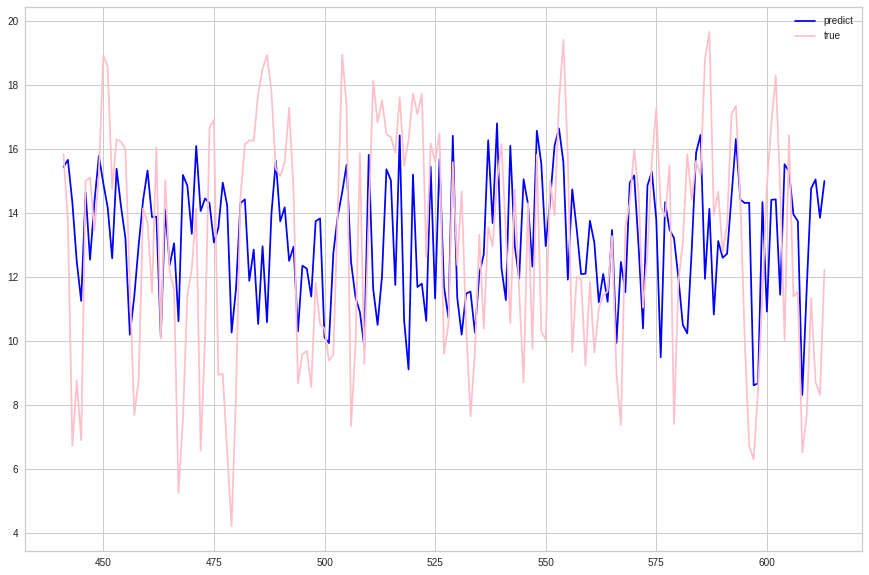

In [ ]:
#visualise on the training set 
plt.figure(figsize=(15, 10))

pyplot.plot(predictions_future["Label"], label='predict', color = 'blue')
pyplot.plot(predictions_future["pm10"], label='true', color = 'pink')
pyplot.legend()

pyplot.show()
#oversimplifies the up and downs, but it's not picking up the extreme values 